In [2]:
#necessary module
import os ; import sys
sys.path.append(os.getcwd()+"/Equantum")
#path to data
datapath="/scratch/zhaoyuha/Datas/EQuantum_data/"
from sites import Site
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from fsc import FSC
import scipy.linalg as sl
import importlib
import poissonsolver as psolver
import kwant
import scipy.io as sio
%matplotlib widget

from EQsystem import System

In [3]:
import fsc
importlib.reload(fsc)
from fsc import FSC

#test module
import solvers
importlib.reload(solvers)
from solvers import local_solver

import qbuilder
importlib.reload(qbuilder)

from scipy.interpolate import interp1d
from scipy.optimize import brentq

In [9]:
def density_function(r):
        spacing0 = 0.09 # spacing at r=0
        k = 0.8    # spacing increases by 0.05 per unit distance
        return spacing0 + k * r

    # Define a 3D simulation box: ((xmin, xmax), (ymin, ymax), (zmin, zmax))
    

In [10]:
testparams={"lattice_type": "square",   # or honeycomb_lattice, etc.
"box_size": ((-1.7, 1.7), (-3.2, 3.2), (-0.5, 0.5)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

In [11]:
syst=System(testparams)
syst.export_sites(filename="setup/sites.json")

Generated 7159 points in 3D.
Voronoi cells have been created.
2 sites have been removed from the system.
EQsystem is successfully initialized.


In [12]:
syst=System(testparams,config_file="setup/009.json",ifqsystem=True,quantum_builder="default")

Generated 7159 points in 3D.
Voronoi cells have been created.
2 sites have been removed from the system.
Quantum system is generated using default.
EQsystem is successfully initialized.


In [13]:
qparams={'Ufunc': lambda x:0,'phi':0.5}
fsc=FSC(syst,ifinitial=False,params=qparams)

The quantum problem has been initialized.


In [14]:
fsc.update_BC(syst,'gate','potential',50)
fsc.update_BC(syst,'backgate','potential',-180,ifinitial=True)

The poisson problem has been initialized.


In [15]:
qparams['phi']=0.4
fsc.qsystem.update_params(qparams)

In [22]:
Htest=fsc.qsystem.H.toarray()

In [ ]:
ev=np.sort(sl.eigvals(Htest))

In [16]:
ildos=qbuilder.update_ildos(fsc,syst,ntries=20)

IndexError: index 0 is out of bounds for axis 0 with size 0

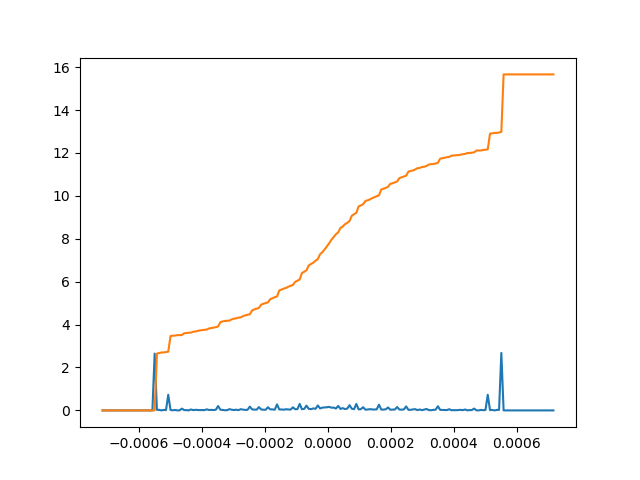

In [25]:
plt.figure()
plt.plot(ildos[0][0],ildos[0][1])
plt.plot(ildos[0][0],[np.sum(ildos[0][1][:idx])for idx,ee in enumerate(ildos[0][0])])
plt.show()

In [64]:
fsc.solve(syst,save=datapath+"test")

0.002139969811028132 -0.0002514720995897182
-1.7481758586266244e-10 1.922144062535687e-11
The iteration has been conducted for  [0, 0, 0] times.
{'ni_error': [1, 1.243417262365793e-14, 0.0, -6.978362186746797e-16, -7.49673636106737e-05], 'Qprime_len': [34191, 34191, 34191, 34191], 'ildos_error': [1]}
3.480796693972709e-08 -4.433235520728262e-09
The iteration has been conducted for  [0, 1, 0] times.
{'ni_error': [1, 1.243417262365793e-14, 0.0, -6.978362186746797e-16, -7.49673636106737e-05, -1.3216098533382744e-09], 'Qprime_len': [34191, 34191, 34191, 34191, 34191], 'ildos_error': [1]}
-9.804719956991248e-11 1.760460006903231e-11
The iteration has been conducted for  [0, 2, 0] times.
{'ni_error': [1, 1.243417262365793e-14, 0.0, -6.978362186746797e-16, -7.49673636106737e-05, -1.3216098533382744e-09, 5.248178854140986e-12], 'Qprime_len': [34191, 34191, 34191, 34191, 34191, 34191], 'ildos_error': [1]}
-3.532553889720224e-10 4.250834749305645e-11


In [26]:
data=sio.loadmat(datapath+"test")
Uis=data['Uis']
nis=data['nis']

In [ ]:
for ii in tqdm(range(1)):
    fsc.local_solver()
    fsc.update_Qprime()
    psolver.calculate_delta(fsc)
    fsc.Ci=psolver.solve_capacitance(fsc)

In [112]:
fsc.update_Poisson()

In [18]:
sidx=1335
ni=fsc.ni[fsc.Qprime][sidx]
Ci=fsc.Ci[sidx]
ildos=fsc.ildos[sidx]
Ui=fsc.Ui[fsc.Qprime][sidx]

x_dis=ildos[0]-Ui
y_dis=ildos[1]
ildos_dis=[np.sum(y_dis[:idx]) for idx in range(len(x_dis))]
ildos_dis=ildos_dis
ildos_iterp=interp1d(x_dis,ildos_dis,kind='linear',fill_value='exptrapolate')
def dn_for_Ci(dU):
    return -dU*Ci+ni
def diff(dU):
    return np.abs(dn_for_Ci(dU)-ildos_iterp(dU))

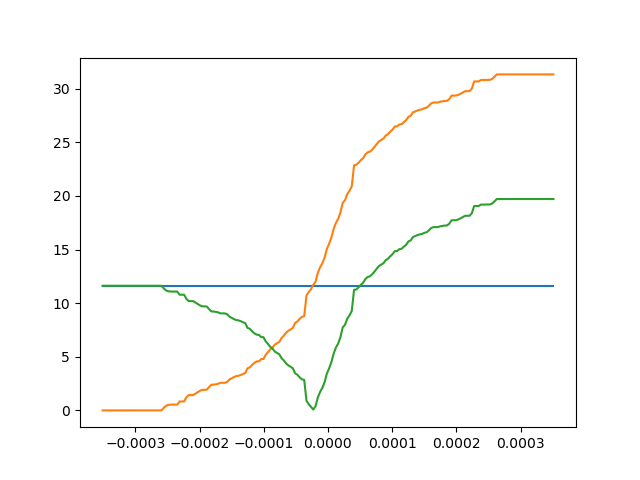

In [19]:
dUs=np.linspace(-5,5,200)*fsc.t
plt.figure()
plt.plot(x_dis,[dn_for_Ci(dU) for dU in x_dis])
plt.plot(x_dis,[ildos_iterp(dU) for dU in x_dis])
plt.plot(x_dis,[diff(dU) for dU in x_dis])
#plt.plot(x_dis,ildos_dis)
#plt.plot(fsc.ildos[0][0],fsc.ildos[0][1])
plt.show()

In [51]:
fsc.t*5

0.0007163694220046518

In [45]:

limits=[-0.5,0.5]
try:
    dUsol=brentq(diff,limits[0],limits[1])
except ValueError:
    print(diff(limits[0]),diff(limits[1]))
dnsol=dn_for_Ci(dUsol)

In [89]:
dUdn=solvers.local_solver(fsc)

0.781144232348572 0.06644391228077529
The potential at site 620 cannot be fully screened.
0.7800291008075 0.06483012942603195
The potential at site 621 cannot be fully screened.
0.8498444001351392 0.04825474022291454
The potential at site 629 cannot be fully screened.
0.7894827804049649 0.10806480680076025
The potential at site 630 cannot be fully screened.
0.8468297340391434 0.06812250665060948
The potential at site 639 cannot be fully screened.
0.8557557866754449 0.060189146612836586
The potential at site 640 cannot be fully screened.
0.81017347400815 0.09832942636340203
The potential at site 649 cannot be fully screened.
0.8237791899020036 0.04207496491638474
The potential at site 658 cannot be fully screened.
0.8332662281952955 0.03018396471936491
The potential at site 659 cannot be fully screened.
0.7807459265526794 0.06373774233115248
The potential at site 668 cannot be fully screened.
0.8473584154328723 0.061642490648028514
The potential at site 677 cannot be fully screened.
0.8

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


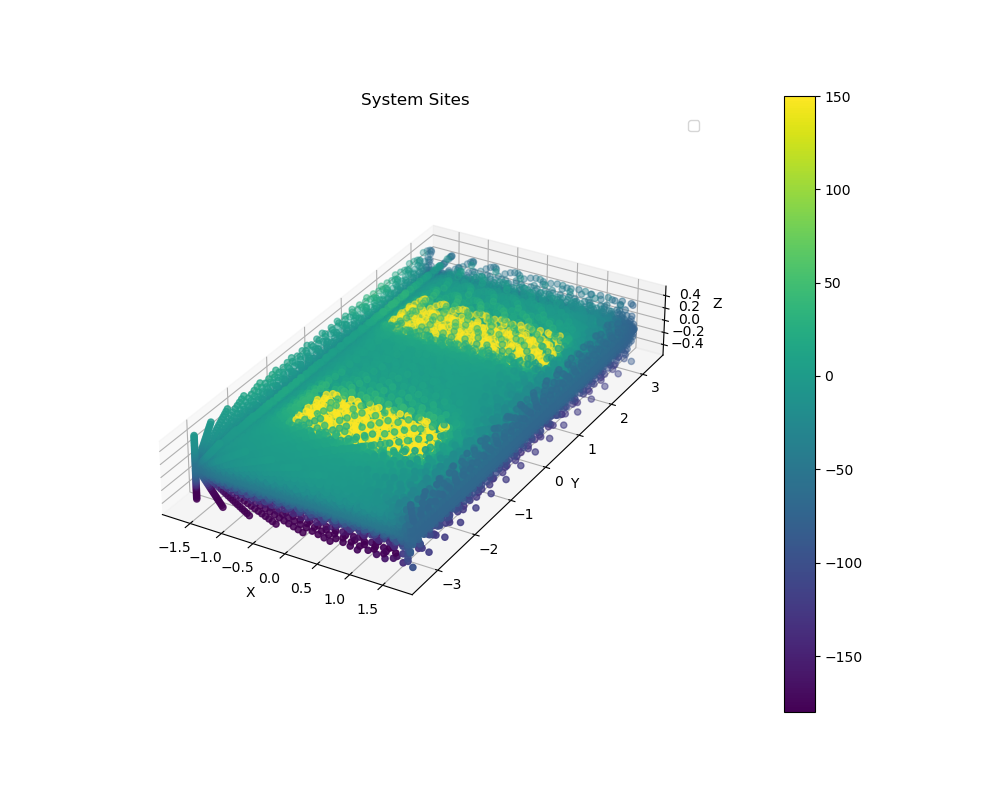

In [72]:
indicate=np.zeros(len(fsc.sites))
indicate[fsc.D_indices]=1
fsc.plot_full(fsc.Ui)

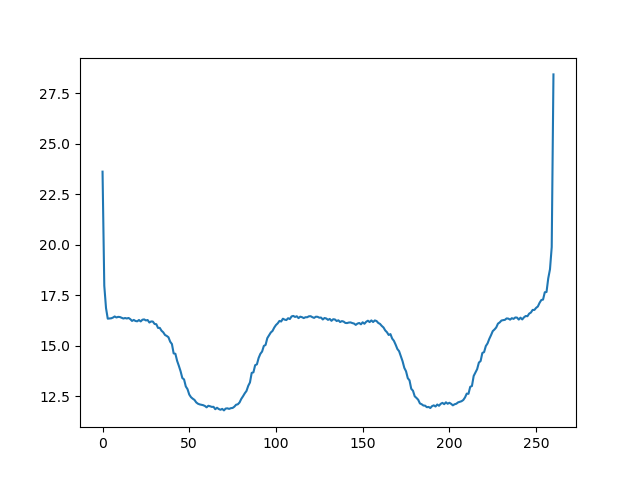

In [69]:
cut_idx=[idx for idx in range(len(fsc.sites)) if np.abs(fsc.sites[idx].coordinates[0])<0.01 and fsc.sites[idx].material=='Qsystem']
plt.figure()
plt.plot(fsc.ni[cut_idx])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


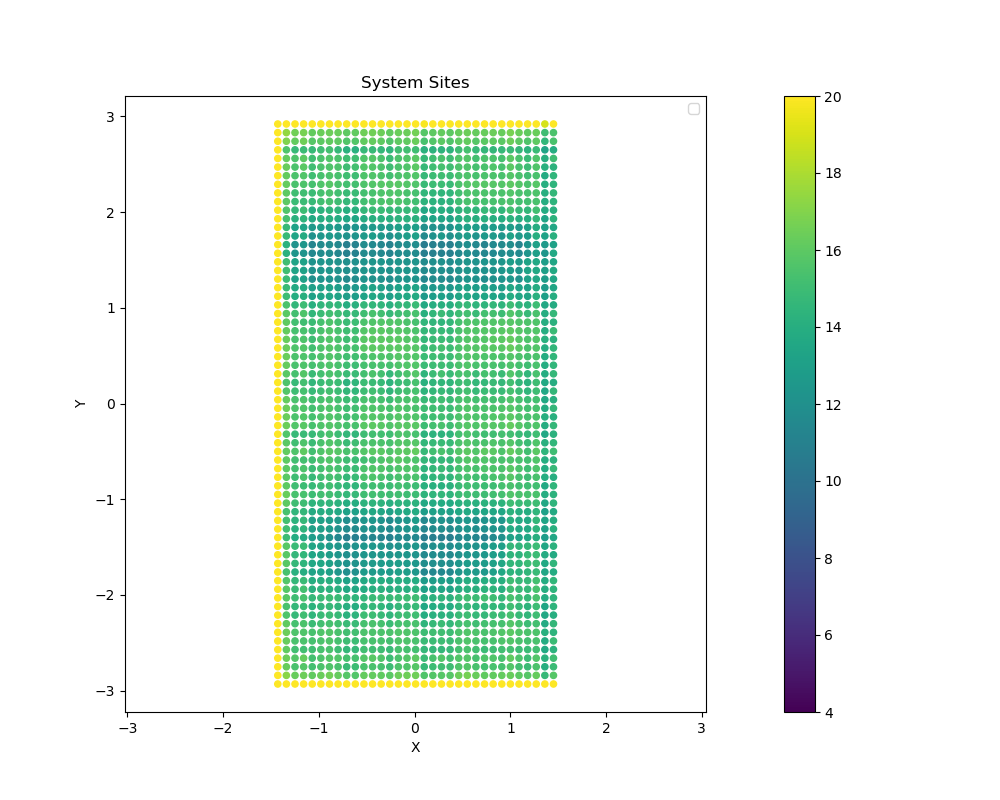

In [17]:
indicate=np.zeros(len(fsc.Qsites))
indicate[1335]=1
plotdata=fsc.ni[fsc.Qsites]
#plotdata=dUdn[1]
fsc.plot_qsystem(plotdata,vmin=4,vmax=20)

In [27]:
from scipy.interpolate import interp1d
x_dis=fsc.ildos[0][0]
y_dis=fsc.ildos[0][1]
ildos_dis=[np.sum(y_dis[:idx]) for idx in range(len(x_dis))]

ildos_iterp=interp1d(x_dis,ildos_dis,kind='linear',fill_value='exptrapolate')

In [61]:
len(fsc.Qsites)

3696

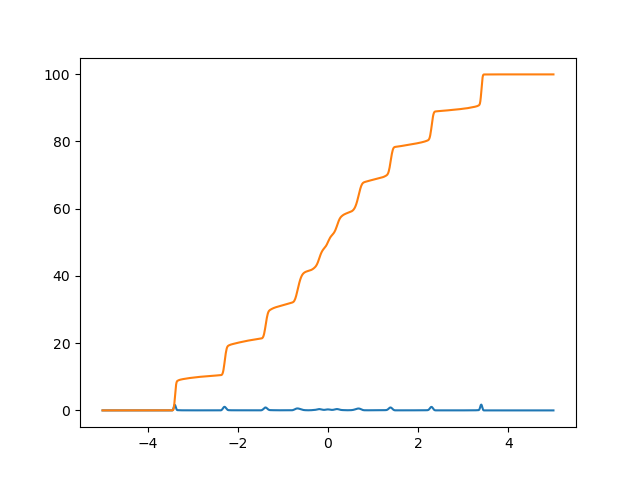

In [28]:
plt.figure()
plt.plot(x_dis,y_dis)
plt.plot(x_dis,[ildos_iterp(x) for x in x_dis])
plt.show()

In [43]:
np.array(range(len(fsc.Qsites)))[np.argsort(list(fsc.Qsites_map.values()))]

array([3538, 3537, 3536, ..., 7196, 7197, 7198])

In [87]:
fsc.qparams['phi']=2

In [ ]:
fsc.initial_Quantum(syst)

In [123]:
syst.qsystem.sites[-3].family.name

'7196'

In [88]:
k_to_q_map=np.array(list(fsc.Qsites_map.values()))
ham_mat=fsc.qsystem.hamiltonian_submatrix(to_sites=k_to_q_map,from_sites=k_to_q_map,params=fsc.qparams)
ew,ev=sl.eigh(ham_mat)

In [54]:
k_to_q_map

array([3539, 3538, 3537, ..., 7196, 7197, 7198])

In [71]:
np.sum(np.abs(ev[1]))

1.0

In [89]:
ev=np.array([evv/np.sum(np.abs(evv)) for evv in ev])

In [94]:
sort_idx=np.argsort(ew)

nden=np.zeros(len(fsc.ni))

for eidx,ee in enumerate(ew):
    if ee <=-2:
        kdos=np.abs(ev[eidx,:])
        nden[fsc.Qsites]+=kdos

In [53]:
kdos

array([1.80259661e-05, 5.52889414e-07, 3.48629165e-05, ...,
       3.48625775e-05, 5.54748562e-07, 1.80259236e-05])

In [26]:
coords = np.array([site.coordinates for site in fsc.sites.values()])[fsc.Qsites]
prop_values = np.array(nden)

In [31]:
np.max(nden)

44.65576076671021

/tmp/ipykernel_3419339/115812251.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


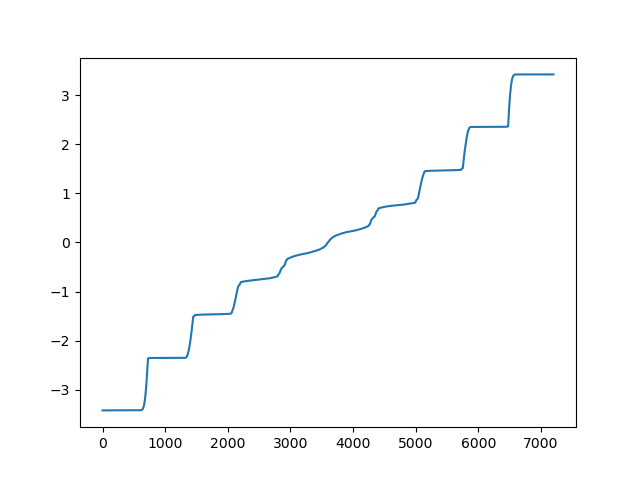

In [91]:
plt.figure()
plt.plot(ew)
plt.show()

In [58]:
import matplotlib.cm as cm

In [57]:
kcoord=np.array([site.pos for site in syst.qsystem.sites])
qcoord=np.array([list(syst.sites.values())[i].coordinates for i in syst.Qsites])
qcoord=qcoord[:,[0,1]]

In [81]:
from scipy.spatial import KDTree

In [84]:
tree = KDTree(kcoord)
    # Define a threshold for matching (this depends on your precision; adjust as needed)
threshold = 1e-5
# Create a dictionary (or array) to store the mapping: 
# mapping[i] will be the index in kwant_coords corresponding to input_coords[i].
mapping = {}
for i, coord in enumerate(qcoord):
    # Query the KDTree for the nearest neighbor.
    dist, idx = tree.query(coord)
    # Optionally, you can check if the distance is below a threshold.
    if dist < threshold:
        mapping[i] = idx
    else:
        # Even if the distance is larger than expected, you might decide to assign it anyway.
        mapping[i] = idx
# mapping now gives the index correspondence between input_coords and kwant_coords.
fsc.Qsites_map=mapping

In [86]:
k_to_q_map

array([3538, 3537, 3536, ..., 7196, 7197, 7198])

In [89]:
mapping.values()

dict_values([3539, 3538, 3537, 3536, 3535, 3534, 3533, 3531, 3530, 3532, 3529, 3528, 3527, 3526, 3525, 3524, 3523, 3521, 3520, 3522, 3519, 3518, 3517, 3516, 3515, 3514, 3513, 3512, 3510, 3511, 3509, 3508, 3507, 3506, 3505, 3504, 3503, 3502, 3499, 3501, 3498, 3497, 3496, 3495, 3494, 3493, 3492, 3491, 3489, 3490, 3488, 3487, 3486, 3485, 3484, 3483, 3482, 3481, 3480, 3500, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3550, 3549, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3560, 3559, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3570, 3569, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3581, 3579, 3580, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3591, 3589, 3590, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3420, 3419, 3418, 3417, 3416, 3415, 3414, 3413, 3411, 3410, 3412, 3409, 3408, 3407, 3406, 3405, 3404, 3403, 3401, 3400, 3402, 3399, 3398, 3397, 3396, 3395, 3394, 3393, 3392, 3390, 3391, 3389, 3388, 3387, 3386, 3385, 3384, 3383, 3382, 3379, 3381, 3378, 3377, 3376, 3375, 337

In [79]:
[-0.05,-0.05] in qcoord

False

In [83]:
np.sum(nden)

7199.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


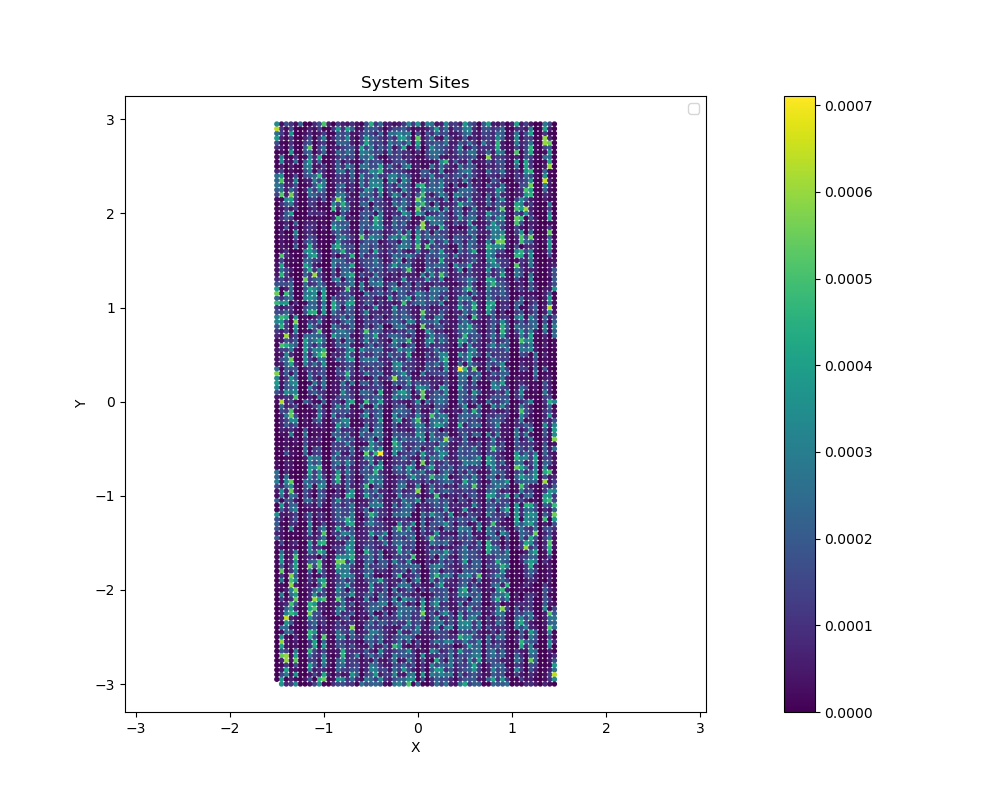

In [96]:
prop_values=kdos[k_to_q_map]
fig, ax=plt.subplots(figsize=(10,8))

# Color sites based on a continuous property, e.g., "charge".


# Create a normalization and a ScalarMappable for the colormap.
#norm = mcolors.Normalize(vmin=np.min(prop_values), vmax=np.max(prop_values))
cmap = cm.viridis
sc = ax.scatter(kcoord[:, 0], kcoord[:, 1],
                c=prop_values, cmap=cmap, s=8,vmin=np.min(prop_values), vmax=np.max(prop_values))
# Add a colorbar to indicate the property values.
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
#cbar.set_label(prop_values)
#box_size=self.geometry_params['box_size']
#ax.set_box_aspect((box_size[0][1]-box_size[0][0], box_size[1][1]-box_size[1][0], box_size[2][1]-box_size[2][0]))
ax.axis('equal')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("System Sites")
ax.legend()
plt.show()

In [ ]:
kwant.Builder()
stest=kwant.

In [27]:
fsc.ni[np.array([1,2,3])]

array([0., 0., 0.])

In [ ]:
import pycula

In [34]:
psolver.calculate_delta(fsc)

In [35]:
N_sites_num=len(fsc.N_indices)
n_N = np.zeros(N_sites_num)
common_indices_N = list(set(fsc.Qprime+fsc.material_indices["dopants"]).intersection(fsc.N_indices))
for nNidx,idx in enumerate(common_indices_N):
    n_N[nNidx]=fsc.sites[idx].charge
U_D = np.array([fsc.sites[i].potential for i in fsc.D_indices])

sol= psolver.solve(fsc.A_mixed,psolver.assemble_input(fsc,n_N,U_D))

/scratch/zhaoyuha/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [36]:
from scipy.sparse import lil_matrix, identity, hstack, vstack
total = fsc.num_sites

    # Partition sites by boundary condition type.
    

# Assemble the full finite-volume matrix Δ and full source vector b.
A_full = lil_matrix((total, total))
b_full = np.zeros(total)
for i, site in fsc.sites.items():
    diag_val = 0.0
    for j, face_area in site.neighbors.items():
        neighbor = fsc.sites[j]
        d = np.linalg.norm(np.array(site.coordinates) - np.array(neighbor.coordinates))
        avg_dielectric = 2.0 /(1/site.dielectric_constant + 1/neighbor.dielectric_constant)
        coeff = avg_dielectric * face_area / d
        diag_val += coeff
        A_full[i, j] = -coeff
    A_full[i, i] = diag_val
    # b_full represents the source term (e.g., the charge) at each site.
    b_full[i] = site.charge

A_full = A_full.tocsr()

# Partition A_full into blocks corresponding to Neumann (N) and Dirichlet (D) sites.
A_NN = A_full[fsc.N_indices, :][:, fsc.N_indices]
A_ND = A_full[fsc.N_indices, :][:, fsc.D_indices]
A_DN = A_full[fsc.D_indices, :][:, fsc.N_indices]
A_DD = A_full[fsc.D_indices, :][:, fsc.D_indices]
#update the delta matrix
fsc.Delta_matrix=[A_NN,A_ND,A_DN,A_DD]

# define A_mixed matrix
zero_block = lil_matrix((len(fsc.N_indices), len(fsc.D_indices)))
top_block = hstack([A_NN, zero_block])
# For Dirichlet sites: row = [ Δ_DN   -I ]
I_D = identity(len(fsc.D_indices), format='lil')
bottom_block = hstack([A_DN, -I_D])
#update the A_mixied
fsc.A_mixed = vstack([top_block, bottom_block]).tocsr()

In [132]:
fsc.Ci=psolver.solve_capacitance(fsc)

In [87]:
fsc.Delta_matrix

In [48]:
len()

188

In [43]:
neighbor=fsc.sites[430]

In [63]:
neighbor

Site(id=82, coord=[-0.6800000071525574, 1.0399999618530273, -0.10000000149011612], potential=0.0, charge=0.0)

In [36]:
len(psolver.assemble_input(fsc,n_N,U_D))

3226

In [50]:
len(A_NN.toarray())

1680

In [38]:
np.linalg.matrix_rank(A_NN.toarray())

1516

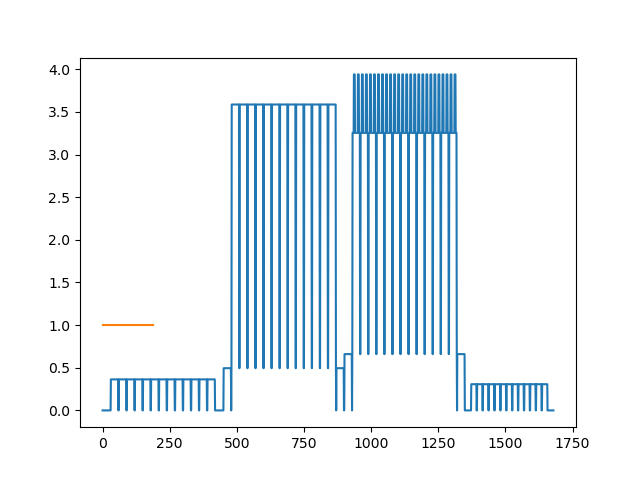

In [56]:
plt.figure()
#plt.plot(UnnD)
#plt.plot(psolver.assemble_input(fsc,n_N,U_D))
#plt.plot(n_N)
plt.plot(np.diag(A_NN.toarray()))
plt.plot([1 for site in noneighbor])
#plt.imshow(np.abs(fsc.A_mixed.toarray()),cmap='Blues')
#plt.imshow(A_NN.toarray(),cmap='Blues')
plt.show()

In [16]:
UnnD=psolver.solve_NDpoisson(fsc)
fsc.ni[fsc.D_indices]=UnnD[len(fsc.N_indices):]
fsc.Ui[fsc.N_indices]=UnnD[:len(fsc.N_indices)]

In [14]:
UnnD[-:]

TypeError: only integer scalar arrays can be converted to a scalar index

In [16]:
syst.export_sites(filename="setup/sites.json")

In [17]:
syst.update_sites_from_blender(filename="setup/updated_sites.json")

In [34]:
def Ufunc(site):
    return 0
kparams={'Ufunc':Ufunc,
         'phi':0.08/0.05}

In [54]:
spectrum=kwant.kpm.SpectralDensity(syst.qsystem,params=kparams,energy_resolution=0.04)

In [75]:
import numpy as np
from scipy.spatial import KDTree

# Assume these are your coordinates:
# input_coords: a numpy array of shape (N, d) for your original site coordinates.
# kwant_coords: a numpy array of shape (N, d) for the coordinates as stored in Kwant.
# For example:
# input_coords = np.array([...])
# kwant_coords = np.array([...])

# Build a KDTree on the Kwant coordinates.
tree = KDTree(kcoord)

# Define a threshold for matching (this depends on your precision; adjust as needed)
threshold = 1e-8

# Create a dictionary (or array) to store the mapping: 
# mapping[i] will be the index in kwant_coords corresponding to input_coords[i].
mapping = {}
for i, coord in enumerate(qcoord):
    # Query the KDTree for the nearest neighbor.
    dist, idx = tree.query(coord)
    # Optionally, you can check if the distance is below a threshold.
    if dist < threshold:
        mapping[i] = idx
    else:
        # Even if the distance is larger than expected, you might decide to assign it anyway.
        mapping[i] = idx

# mapping now gives the index correspondence between input_coords and kwant_coords.

In [2]:
from qsystem import QuantumSystem

In [82]:
kcoord[mapping[0]]

array([-1.5, -3. ])

In [71]:
qcoord=np.array([list(syst.sites.values())[i].coordinates for i in syst.Qsites])
qcoord=qcoord[:,[0,1]]


In [73]:
kcoord

array([[-0.05      , -0.05      ],
       [-0.05      , -0.1       ],
       [-0.05      , -0.15000001],
       ...,
       [ 1.5       ,  2.9000001 ],
       [ 1.5       ,  2.95000005],
       [ 1.5       ,  3.        ]])

In [72]:
kcoord=np.array([site.pos for site in syst.qsystem.sites])

In [55]:
energies, densities = spectrum()

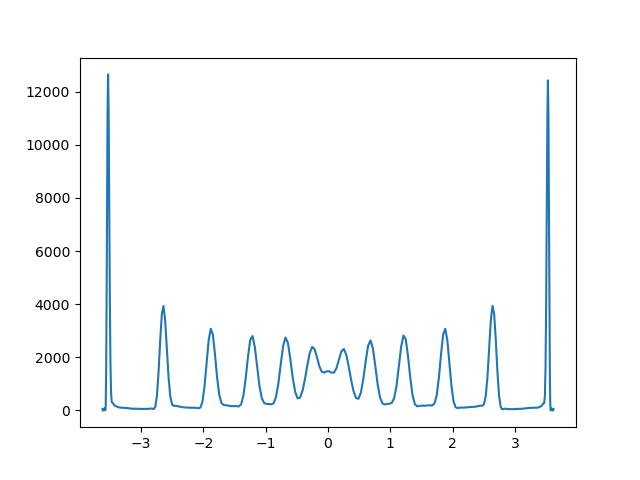

In [56]:
plt.figure()
plt.plot(energies,densities)
plt.show()

In [ ]:
ham_mat=syst.qsystem.hamiltonian_submatrix(params=kparams)
ev=np.sort(sl.eigvals(ham_mat))

In [ ]:
Erange=np.linspace(-4,4,200)
dostest=np.zeros(len(Erange))

for idx, ee in enumerate(Erange):
    count=0
    for ene in ev:
        if np.abs(ene-ee)<0.02:
            count+=1
    dostest[idx]=count

In [63]:
len(ev)

7381

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



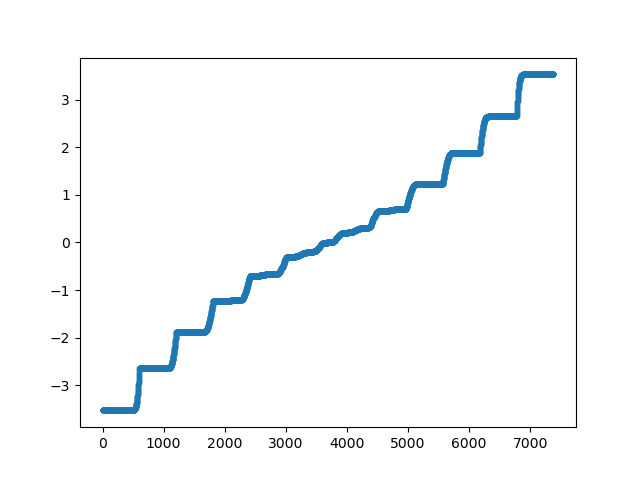

In [62]:
plt.figure()
#plt.imshow(np.imag(ham_mat))
plt.plot(ev,'.')
#plt.plot(Erange,dostest)
#plt.plot(energies,densities/np.sum(densities)*np.sum(dostest))
plt.show()

In [25]:
len(densities)

200

In [191]:
energy_subset = np.linspace(-1, 3)
density_subset = spectrum(energy_subset)

In [209]:
energy_subset2 = np.linspace(-1, 3)
density_subset2 = spectrum2(energy_subset2)

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



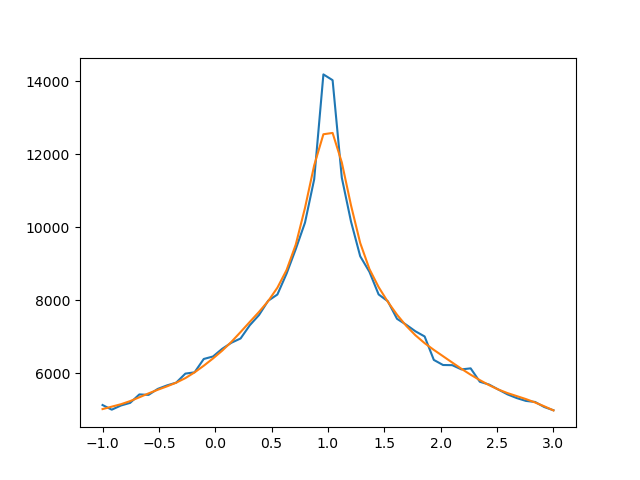

In [210]:
plt.figure()
plt.plot(energy_subset,density_subset)
plt.plot(energy_subset2,density_subset2)
plt.show()

In [3]:
stest=kwant.Builder()
lat=kwant.lattice.square(a=0.05,norbs=1)

In [4]:
sbox=[[-1.5, 1.5], [-3.0, 3.0]]

In [2]:
def qshape(box):
    def ifinshape(pos):
        x,y=pos
        return box[0][0]<=x<=box[0][1] and box[1][0]<=y<=box[1][1]
    return ifinshape

In [5]:
def onsite(site,Ufunc):
    return Ufunc(site)

In [6]:
def mag_hop(to_site,from_site,phi):
    x=from_site.tag[0]
    return np.exp(1j*2*np.pi*phi*x)

In [7]:
stest[lat.shape(qshape(sbox),(0,0))]=onsite
stest[lat.neighbors()]=mag_hop
stest=stest.finalized()

In [8]:
def Ufunc(site):
    return 0

In [38]:
ham_mat=stest.hamiltonian_submatrix(params={'Ufunc':Ufunc,'phi':0.3})
ew,ev=sl.eig(ham_mat)

/scratch/zhaoyuha/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


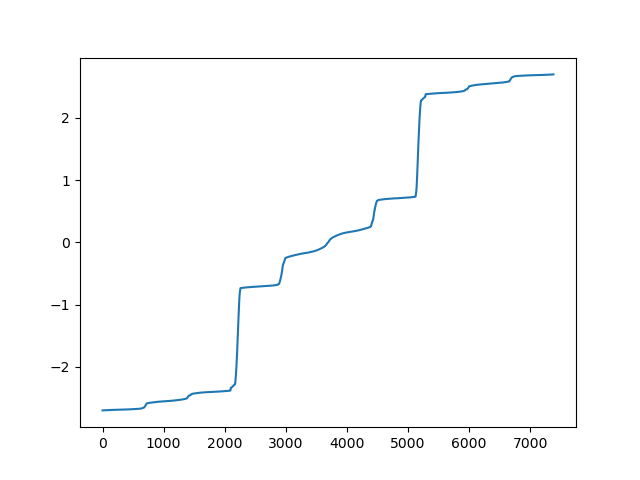

In [43]:
plt.figure()
plt.plot(np.sort(ew))
plt.show()

In [47]:
sort_idx=np.argsort(ew)
nden=np.zeros(len(stest.sites))

for eidx,ee in enumerate(ew):
    if ee <-1.5:
        kdos=np.abs(ev[sort_idx[eidx],:])
        nden+=kdos

In [22]:
import matplotlib.cm as cm

In [36]:
kcoord=np.array([site.pos for site in stest.sites])

In [35]:
stest.sites[1].pos

array([-1.5, -2.95])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


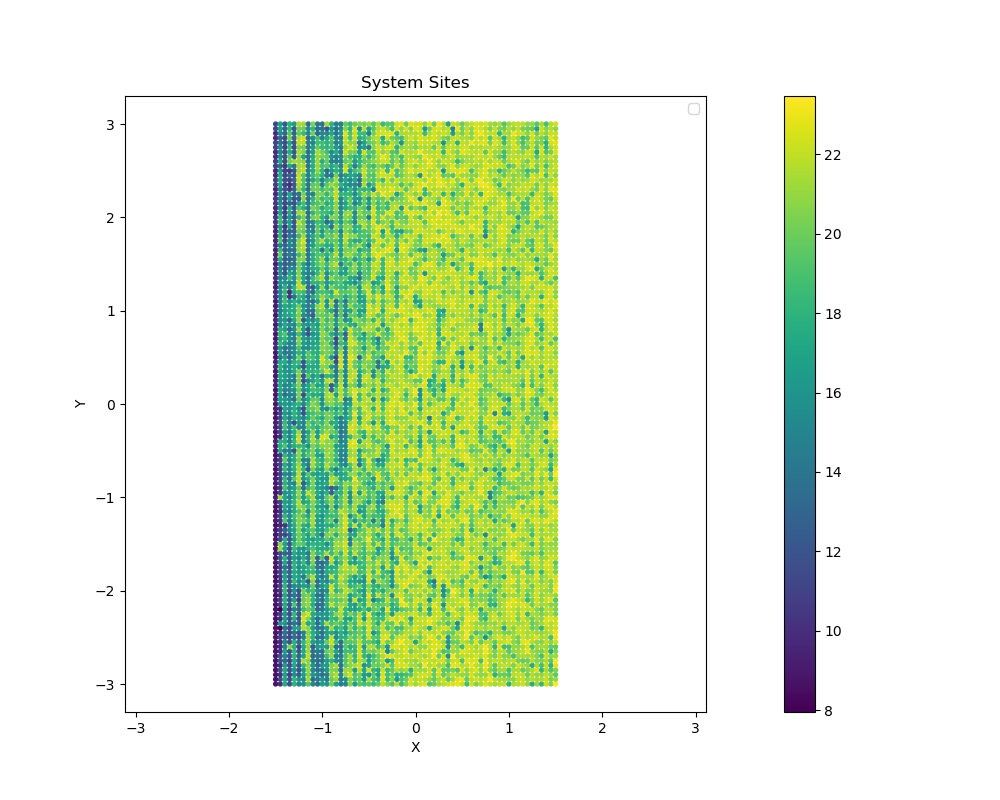

In [48]:
prop_values=nden
fig, ax=plt.subplots(figsize=(10,8))

# Color sites based on a continuous property, e.g., "charge".


# Create a normalization and a ScalarMappable for the colormap.
#norm = mcolors.Normalize(vmin=np.min(prop_values), vmax=np.max(prop_values))
cmap = cm.viridis
sc = ax.scatter(kcoord[:, 0], kcoord[:, 1],
                c=prop_values, cmap=cmap, s=8,vmin=np.min(prop_values), vmax=np.max(prop_values))
# Add a colorbar to indicate the property values.
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
#cbar.set_label(prop_values)
#box_size=self.geometry_params['box_size']
#ax.set_box_aspect((box_size[0][1]-box_size[0][0], box_size[1][1]-box_size[1][0], box_size[2][1]-box_size[2][0]))
ax.axis('equal')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("System Sites")
ax.legend()
plt.show()

In [39]:
spectrum2=kwant.kpm.SpectralDensity(stest,params={'Ufun':Ufun,'phi':0.01},energy_resolution=0.1)

In [40]:
energies,densities=spectrum2()

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



<function matplotlib.pyplot.show(block=None)>

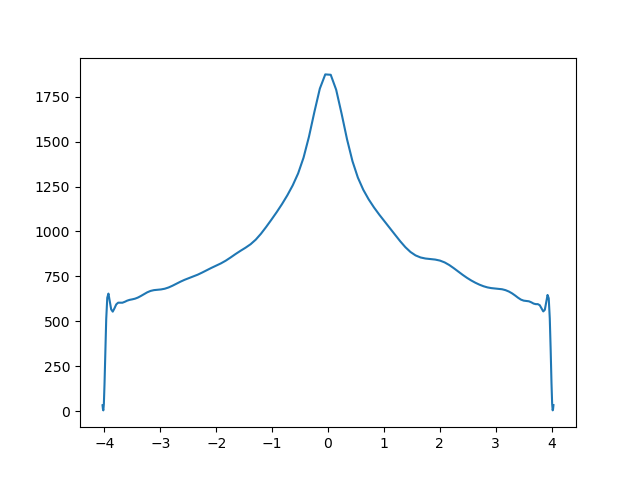

In [41]:
plt.figure()
plt.plot(energies,densities)
plt.show

In [18]:
import scipy.linalg as sl

In [1]:
ham_mat=stest.hamiltonian_submatrix(params={'Ufun':Ufun,'phi':0.1})
#ev=np.sort(sl.eigvals(ham_mat))

NameError: name 'stest' is not defined

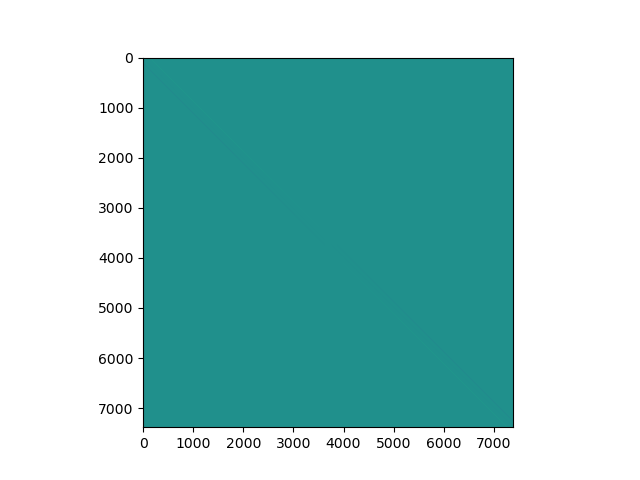

In [44]:
plt.figure()
plt.imshow(np.imag(ham_mat))
#plt.plot(ev)
plt.show()

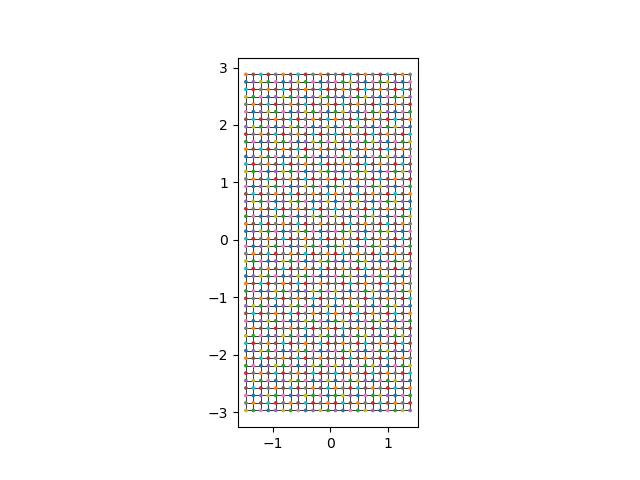

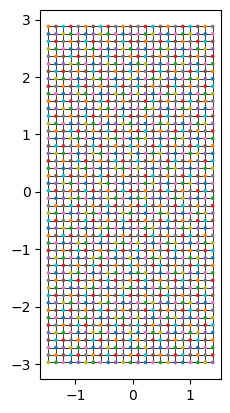

In [39]:
kwant.plot(syst.qsystem)

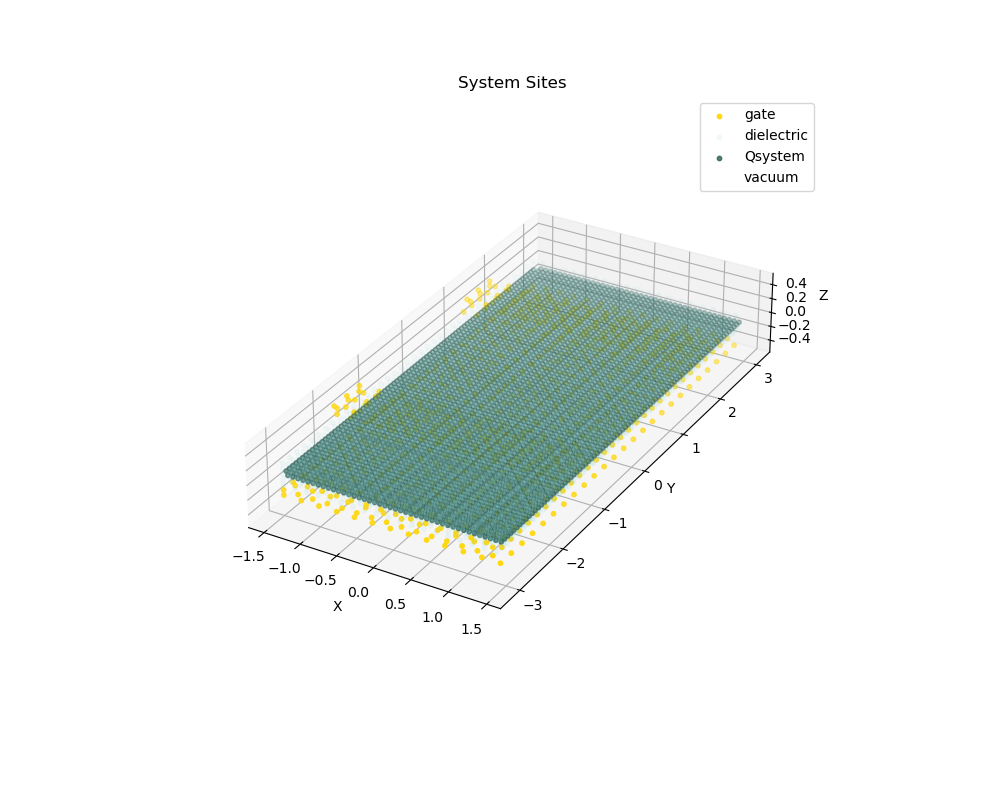

In [19]:
syst.plot_geometry()

In [ ]:
syst.export_sites("sites.json")

In [54]:
import json

In [55]:
with open("setup/updated_sites.json", "r") as f:
    updated_data = json.load(f)

In [56]:
len(updated_data)

300137

In [19]:
import pyvista as pv
import numpy as np

def plot_voronoi_3d(vor):
    plotter = pv.Plotter()
    # The 3D Voronoi object contains regions that might not be closed.
    # Here we attempt to create surfaces from the finite regions.
    for region in vor.regions:
        if not region or -1 in region:
            continue
        # Create a PolyData object from the region vertices.
        region_points = vor.vertices[region]
        try:
            # Use Delaunay triangulation to form a surface.
            poly = pv.PolyData(region_points)
            surface = poly.delaunay_3d(alpha=1.0)
            if surface.n_cells > 0:
                plotter.add_mesh(surface, opacity=0.5, show_edges=True)
        except Exception as e:
            print("Failed to create a surface for a region:", e)
    
    # Add the original points for reference.
    plotter.add_points(vor.points, color="red", point_size=10)
    plotter.show()

# Example usage:
# vor = geometry3d.compute_voronoi()  # assuming geometry3d is an instance of your Geometry3D class.
# plot_voronoi_3d(vor)

In [ ]:
vor = geom3d.compute_voronoi()  # assuming geometry3d is an instance of your Geometry3D class.
plot_voronoi_3d(vor)

In [8]:
import pyvista as pv
pv.set_jupyter_backend('trame')

In [16]:
def polygon_area(vertices):
    """
    Compute the area of a planar convex polygon in 3D.
    
    This function triangulates the polygon using the first vertex as a reference.
    
    Parameters:
    - vertices: np.ndarray of shape (N,3) representing the polygon vertices in order.
    
    Returns:
    - area: float, the computed area of the polygon.
    """
    if len(vertices) < 3:
        return 0.0
    v0 = vertices[0]
    area = 0.0
    for i in range(1, len(vertices) - 1):
        v1 = vertices[i]
        v2 = vertices[i + 1]
        triangle_area = 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))
        area += triangle_area
    return area

In [17]:

def create_sites_from_geometry_3d(geometry3d):
    """
    Create Site objects from a Geometry3D instance.
    
    This function assumes that geometry3d.points is an array of shape (N, 3) and that
    geometry3d.compute_voronoi() has been called to obtain a 3D Voronoi tessellation.
    It then builds a dictionary of Site objects and populates neighbor relationships
    based on the Voronoi ridges.
    
    Parameters:
    - geometry3d: an instance of your Geometry3D class.
    
    Returns:
    - sites: dict mapping site IDs to Site objects.
    """
    # Get the points and the 3D Voronoi object.
    points = geometry3d.points  # shape (N, 3)
    vor = geometry3d.compute_voronoi()
    
    sites = {}
    num_points = len(points)
    for i in range(num_points):
        # Initialize each site with default values (modify as needed).
        sites[i] = Site(site_id=i, coordinates=points[i], charge=0.0, potential=0.0, dielectric_constant=1.0)
    
    # Use vor.ridge_points and vor.ridge_vertices to assign neighbor relationships.
    # Each ridge corresponds to a common face between two Voronoi cells.
    for ridge, ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        i, j = ridge
        # Skip infinite ridges (if any vertex is -1, it means the ridge is unbounded).
        if -1 in ridge_vertices:
            continue
        # Extract the vertices of the common face.
        face_vertices = vor.vertices[ridge_vertices]
        # Compute the area of the face.
        face_area = polygon_area(face_vertices)
        # Compute the distance between the two sites.
        distance = np.linalg.norm(sites[i].coordinates - sites[j].coordinates)
        # Add neighbor relationship for both sites.
        sites[i].add_neighbor(j, face_area)
        sites[j].add_neighbor(i, face_area)
    
    return sites

In [35]:
list(sites_dict.values())[1].neighbors

{5: 1.1805726928466331,
 10: 0.23232292003798374,
 4: 12.123026442523273,
 21: 38.32674936246214,
 28: 5.210133426222529,
 27: 2.482664655616283}

In [15]:
import mumps

In [42]:
from pymumps import DMumpsContext

ModuleNotFoundError: No module named 'pymumps'

In [9]:
import qsystem
importlib.reload(qsystem)
from qsystem import QuantumSystem

In [10]:
def Ufunc(site):
    return 0

In [11]:
qtest=QuantumSystem(syst,{'Ufunc':Ufunc,'phi':1})

In [12]:
ddtest=qtest.get_dos(ifpara=True,params={'Ufunc':Ufunc,'phi':2},delta=1e-2,npol_scale=8,w=np.linspace(-4,0,2000))

In [15]:
qtest.Qsites[0].id

6557

In [13]:
dtest=qtest.get_ldos(ifpara=True,Ncore=20)

In [27]:
np.where(dtest[1,0,:]<0)[0][-1]

499

In [29]:
len(dtest)

3696

In [30]:
[np.where(dtest[ii,0,:]<=0)[0][-1] for ii in range(len(syst.Qsites))]

[499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499,
 499

In [131]:
cden=[np.sum(ddtest[1][:ii]) for ii in range(len(ddtest[0]))]

In [130]:
ddtest[0]

array([-4.0000000e+00, -3.9979990e+00, -3.9959980e+00, ...,
       -4.0020010e-03, -2.0010005e-03,  0.0000000e+00])

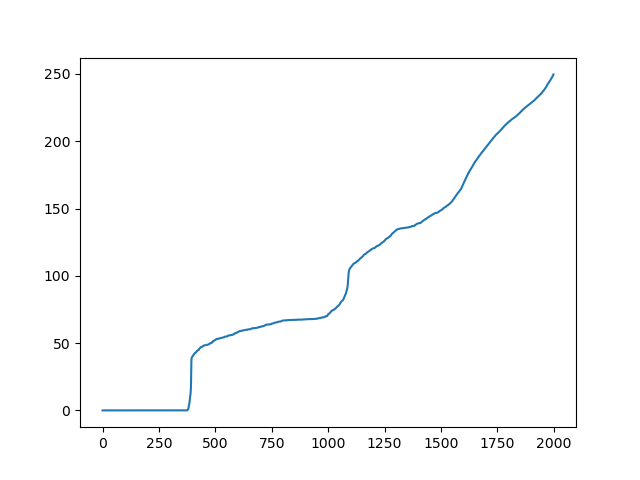

In [132]:
plt.figure()
#plt.plot(ddtest[0],ddtest[1])
plt.plot(cden)
# for ii in range(0,3690,20):
#     plt.plot(dtest[ii][0],dtest[ii][1])
plt.show()